# Experiment 1

1. Create a random sat formula
* n = 10
* k = 3
* r = 4.0, 4.2, 4.4, 4.6


1. Check the number of sat clauses with the following solvers (mean over 10 times)
* Learning solver with greedy baseline trainable initial state
* Learning solver with greedy baseline and zeros initial state

In [1]:
import torch

from src.decoders import RNNDecoder
from src.encoder_decoder import EncoderDecoder
from src.embeddings import BasicEmbedding, IdentityEmbedding
from src.baselines import BaselineRollout
from src.init_states import TrainableState

from src.generator import UniformGenerator
from src.run_solvers import random_solver, learning_solver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

In [2]:
def run_model_zstate(formula, baseline):
    # Architecture
    cell = 'GRU'
    hidden_size = 128
    num_layers = 1
    dropout = 0
    clip_logits_c = 0 #(default: 0)

    ## Embeddings
    embedding_size = 32
    assignment_emb = BasicEmbedding(num_labels=3, embedding_size=embedding_size)
    variable_emb = BasicEmbedding(num_labels=num_variables, embedding_size=embedding_size)
    context_emb = IdentityEmbedding()
    input_size = embedding_size * 2

    # Encoder
    encoder = None
    decoder = RNNDecoder(input_size = input_size,
                        cell = cell,
                        assignment_emb = assignment_emb,
                        variable_emb = variable_emb,
                        context_emb = context_emb,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout,
                        clip_logits_c = clip_logits_c)
    ## Initializers
    init_dec_var = None
    init_dec_context = None
    init_dec_state = None

    ## Network
    policy_network = EncoderDecoder(encoder=encoder,
                                    decoder=decoder,
                                    init_dec_var=init_dec_var,
                                    init_dec_context=init_dec_context,
                                    init_dec_state=init_dec_state)

    # Training hyperparameters
    num_episodes = 500
    accumulation_steps = 1
    lr = 1e-3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #baseline = 
    entropy_weight = 0
    clip_val = 1
    verbose = 1

    variables = None

    # num_sat, history_loss, history_num_sat
    return learning_solver(formula=formula,
                        num_variables=num_variables,
                        variables=variables,
                        encoder=encoder,
                        decoder=decoder,
                        init_dec_var=init_dec_var,
                        init_dec_context=init_dec_context,
                        init_dec_state=init_dec_state, 
                        num_episodes=num_episodes,
                        accumulation_steps=accumulation_steps,
                        lr=lr,
                        device=device,
                        baseline=baseline,
                        entropy_weight=entropy_weight,
                        clip_val=clip_val,
                        verbose=verbose)


def run_model_tstate(formula, baseline):
    # Architecture
    cell = 'GRU'
    hidden_size = 128
    num_layers = 1
    dropout = 0
    clip_logits_c = 0 #(default: 0)

    ## Embeddings
    embedding_size = 32
    assignment_emb = BasicEmbedding(num_labels=3, embedding_size=embedding_size)
    variable_emb = BasicEmbedding(num_labels=num_variables, embedding_size=embedding_size)
    context_emb = IdentityEmbedding()
    input_size = embedding_size * 2

    # Encoder
    encoder = None
    decoder = RNNDecoder(input_size = input_size,
                        cell = cell,
                        assignment_emb = assignment_emb,
                        variable_emb = variable_emb,
                        context_emb = context_emb,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout,
                        clip_logits_c = clip_logits_c)
    ## Initializers
    init_dec_var = None
    init_dec_context = None
    init_dec_state = TrainableState(cell, hidden_size, num_layers, a=-0.8, b=0.8)

    ## Network
    policy_network = EncoderDecoder(encoder=encoder,
                                    decoder=decoder,
                                    init_dec_var=init_dec_var,
                                    init_dec_context=init_dec_context,
                                    init_dec_state=init_dec_state)

    # Training hyperparameters
    num_episodes = 500
    accumulation_steps = 1
    lr = 1e-3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #baseline = 
    entropy_weight = 0
    clip_val = 1
    verbose = 1

    variables = None

    # num_sat, history_loss, history_num_sat
    return learning_solver(formula=formula,
                        num_variables=num_variables,
                        variables=variables,
                        encoder=encoder,
                        decoder=decoder,
                        init_dec_var=init_dec_var,
                        init_dec_context=init_dec_context,
                        init_dec_state=init_dec_state, 
                        num_episodes=num_episodes,
                        accumulation_steps=accumulation_steps,
                        lr=lr,
                        device=device,
                        baseline=baseline,
                        entropy_weight=entropy_weight,
                        clip_val=clip_val,
                        verbose=verbose)

In [3]:
experiment_name = 'exp10'
num_experiments = 10 #num of times each experiment is run

# CNF Formula
num_variables = 20  # Num variables
k = 3   # Clause size
r_list = [4.0, 4.2, 4.4] #Radious

global_step = 0
for _, r in enumerate(r_list):
    print(f'r = {r} ...')

    log_dir='outputs/' + experiment_name + '/runs/n' + str(num_variables) +'/'+str(r)
    writer = SummaryWriter(log_dir = log_dir)        

    # Create a sat generator
    sat_gen = UniformGenerator(min_n = num_variables,
                                max_n = num_variables,
                                min_k = k,
                                max_k = k,
                                min_r = r,
                                max_r = r)
    
    for _ in tqdm(range(num_experiments)):
            
        # Create a random sat formula
        n, r, m, formula = sat_gen.generate_formula()

        ##################################################################
        # Random solver                                                  #
        ##################################################################
        num_sat = random_solver(n, formula)
        writer.add_scalar('random', num_sat, global_step, new_style=True)


        ##################################################################
        # Learning model with 1-sampled basleine                         #
        ##################################################################
        baseline = BaselineRollout(1)
        num_sat, _,_ = run_model_zstate(formula, baseline)
        writer.add_scalar('learned_gb_zstate', num_sat, global_step, new_style=True)

        ##################################################################
        # Learning model with 2-sampled basleine                         #
        ##################################################################
        baseline = BaselineRollout(2)
        num_sat, _,_ = run_model_tstate(formula, baseline)
        writer.add_scalar('learning_gb_tstate', num_sat, global_step, new_style=True)

        global_step +=1
    
    writer.close()

r = 4.0 ...


  0%|          | 0/10 [00:00<?, ?it/s]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 71.0000


 10%|█         | 1/10 [00:39<05:53, 39.29s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 71.0000
Episode [500/500], Mean Loss -6.6923,  Mean num sat 73.0000


 20%|██        | 2/10 [01:19<05:18, 39.77s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 77.0000
Episode [500/500], Mean Loss 17.8171,  Mean num sat 69.0000


 30%|███       | 3/10 [01:58<04:34, 39.26s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 72.0000
Episode [500/500], Mean Loss 2.1046,  Mean num sat 74.0000


 40%|████      | 4/10 [02:36<03:54, 39.01s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 69.0000
Episode [500/500], Mean Loss 11.8719,  Mean num sat 68.0000


 50%|█████     | 5/10 [03:14<03:13, 38.68s/it]

Episode [500/500], Mean Loss 4.9205,  Mean num sat 74.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 76.0000


 60%|██████    | 6/10 [03:55<02:37, 39.50s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 76.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 72.0000


 70%|███████   | 7/10 [04:36<01:59, 39.95s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 72.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 75.0000


 80%|████████  | 8/10 [05:13<01:18, 39.03s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 75.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 73.0000


 90%|█████████ | 9/10 [05:50<00:38, 38.40s/it]

Episode [500/500], Mean Loss -11.8683,  Mean num sat 69.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 73.0000


100%|██████████| 10/10 [06:29<00:00, 38.92s/it]


Episode [500/500], Mean Loss 0.0000,  Mean num sat 73.0000
r = 4.2 ...


  0%|          | 0/10 [00:00<?, ?it/s]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 81.0000


 10%|█         | 1/10 [00:42<06:23, 42.61s/it]

Episode [500/500], Mean Loss -9.8188,  Mean num sat 75.0000
Episode [500/500], Mean Loss -103.6918,  Mean num sat 65.0000


 20%|██        | 2/10 [01:20<05:16, 39.59s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 77.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 78.0000


 30%|███       | 3/10 [01:59<04:36, 39.51s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 78.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000


 40%|████      | 4/10 [02:35<03:48, 38.06s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 77.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 78.0000


 50%|█████     | 5/10 [03:14<03:12, 38.47s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 81.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 73.0000


 60%|██████    | 6/10 [03:49<02:29, 37.40s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 73.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 80.0000


 70%|███████   | 7/10 [04:26<01:51, 37.15s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 77.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000


 80%|████████  | 8/10 [05:02<01:13, 36.78s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000
Episode [500/500], Mean Loss -34.5993,  Mean num sat 72.0000


 90%|█████████ | 9/10 [05:42<00:37, 37.75s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 77.0000
Episode [500/500], Mean Loss -11.1125,  Mean num sat 75.0000


100%|██████████| 10/10 [06:25<00:00, 38.53s/it]


Episode [500/500], Mean Loss -6.1425,  Mean num sat 76.0000
r = 4.4 ...


  0%|          | 0/10 [00:00<?, ?it/s]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000


 10%|█         | 1/10 [01:05<09:47, 65.25s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 85.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 78.0000


 20%|██        | 2/10 [01:55<07:30, 56.26s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 76.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 80.0000


 30%|███       | 3/10 [02:38<05:51, 50.24s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 81.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 85.0000


 40%|████      | 4/10 [03:20<04:41, 46.97s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 80.0000
Episode [500/500], Mean Loss -5.7274,  Mean num sat 84.0000


 50%|█████     | 5/10 [04:02<03:47, 45.43s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 76.0000
Episode [500/500], Mean Loss -7.4820,  Mean num sat 79.0000


 60%|██████    | 6/10 [04:45<02:57, 44.29s/it]

Episode [500/500], Mean Loss -47.1277,  Mean num sat 76.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000


 70%|███████   | 7/10 [05:30<02:13, 44.59s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 79.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 75.0000


 80%|████████  | 8/10 [06:17<01:30, 45.36s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 76.0000
Episode [500/500], Mean Loss 0.0000,  Mean num sat 82.0000


 90%|█████████ | 9/10 [07:02<00:45, 45.19s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 82.0000
Episode [500/500], Mean Loss -15.2162,  Mean num sat 80.0000


100%|██████████| 10/10 [07:45<00:00, 46.53s/it]

Episode [500/500], Mean Loss 0.0000,  Mean num sat 84.0000


In [10]:
#Upload log_dir
#tensorboard dev upload --logdir 'outputs/exp0/runs/n20'

#from tensorboard experimental to dataframe
#https://tensorboard.dev/experiment/nGoxU6HWQMaduPCXvBpxgw/
experiment_id = 'fJOkvqqsRa6mqqoK5XBRpg'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,4.0,learned_gb_zstate,0,71.0
1,4.0,learned_gb_zstate,1,73.0
2,4.0,learned_gb_zstate,2,78.0
3,4.0,learned_gb_zstate,3,73.0
4,4.0,learned_gb_zstate,4,70.0
...,...,...,...,...
85,4.4,random,25,77.0
86,4.4,random,26,82.0
87,4.4,random,27,77.0
88,4.4,random,28,78.0


In [11]:
#Save dataframe as csv
csv_path = 'csv/sip_exp10.csv'
df.to_csv(csv_path, index=False)

df = pd.read_csv(csv_path)
df

,run,tag,step,value
0,4.0,learned_gb_zstate,0,71.0
1,4.0,learned_gb_zstate,1,73.0
2,4.0,learned_gb_zstate,2,78.0
3,4.0,learned_gb_zstate,3,73.0
4,4.0,learned_gb_zstate,4,70.0
...,...,...,...,...
85,4.4,random,25,77.0
86,4.4,random,26,82.0
87,4.4,random,27,77.0
88,4.4,random,28,78.0


Text(0.5, 1.0, 'Ratio of satisfied clauses')

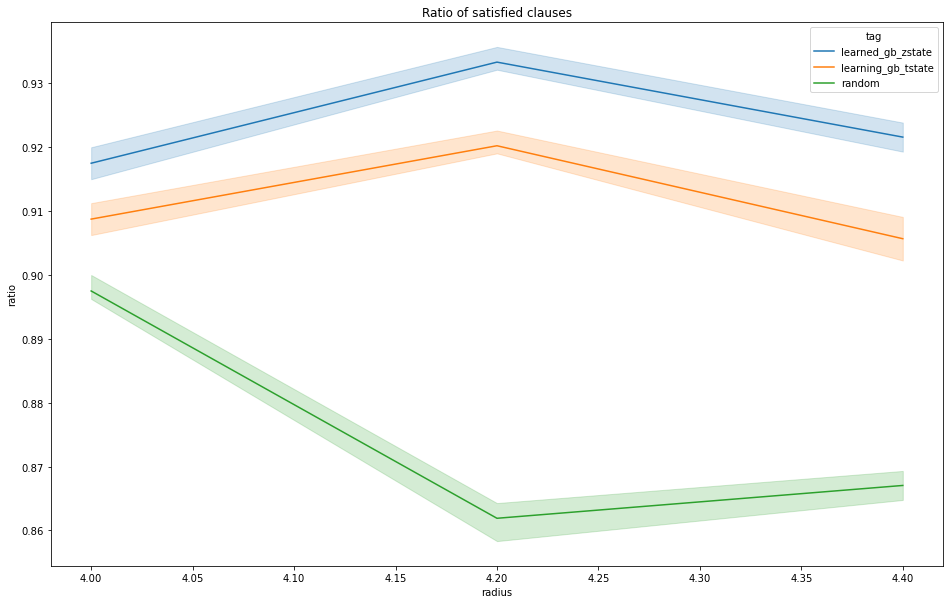

In [12]:
df2 = df.rename(columns = {'run': 'radius'}, inplace = False)

df2['ratio'] = df2['value'] * 1/(df2['radius'].astype(float) * num_variables)

plt.figure(figsize=(16, 10))
sns.lineplot(x='radius', y='ratio', hue='tag', ci=20, data=df2, estimator='mean').set_title("Ratio of satisfied clauses")